# An introduction to sound field control experiments

written by Franz M. Heuchel in March 2021

## Introduction <a name="introduction"></a>

This document is ment to kickstart your experiments with measurement-based sound-field synthesis, that is, the problem of determining optimal loudspeaker signals that produce some desired sound field using measurements of loudspeaker transfer-functions. We will go through three examples, each one of them using some other signal pipeline

- Example 1: [Controlling sound on a laptop](#Example-1:-controlling-sound-on-a-laptop)
- Example 2: [Measurements with external front-end](#Example-2:-measurements-with-B&K-front-end)
- Example 3: [real-time implementation with MAX](#Example-3:-real-time-convolution-with-MAX)

### Code

See [README.md](README.md) for setting up a working conda environment with all required python packages. 

The notebook comes with a collection of functions implemented in the `sfc` module (see [sfc.py](sfc.py)), such that the notebook can focus on demonstrating their useage and visualizing data. Each function is documented via a doc-string in the functions body.

If you are new to Python, make sure to get familiar with the [NumPy](https://numpy.org/doc/stable/user/quickstart.html) package for numerical computation, which is used here extensively (especially the concept of [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html)).

## Example 1: controlling sound on a laptop

You can run this example if you have two loudspeakers connected to outputs 1 and 2 of your sound card and one microphone at input 1. I am using my laptop here, which has stereo loudspeakers and a build-in microphone.

Our goal is to cancel the sound from loudspeaker 1 (the primary source) at the microphone (the control point) by playing an appropriate control signal through loudspeaker two (the secondary or control source). Let $p$ and $c$ be impulse responses of the primary and control loudspeakers to the microphone, let $x$ be a stochastic stationary signal played through the primary sources, let $y=(p*x)$ be the sound from the primary source at the microphone and let $\hat y=(s * (w*x))$ be the sound from the secondary source.

We want to filter the secondary source signal with the FIR filter $w$ of appropriate length such that the total signal energy at the microphone, $\mathbb E[e^2] = \mathbb [(y + \hat y)^2]$, vanishes. If $p$ and $s$ are known and well behaved, an optimal control filter in frequency domain is

$$W = - \frac{PC^*}{|C|^2 + \epsilon}.$$

The regularziation parameter $\epsilon > 0$ makes the filter well-defined.

In the following, we will first estimate the impulse responses $p$ and $s$, compute the optimal filter $w$ and validate our choice by measureing the total sound $y + \hat y$

In [1]:
# automatically reload modules (no kernel restart required while editing source files)
%load_ext autoreload
%autoreload 2
# load libraries
import sfc                       # module for sound field control room
import numpy as np               # numerical computations
import matplotlib.pyplot as plt  # plotting
import sounddevice as sd         # interface to sound cards
from response import Response    # convienience functions for impulse response processing

### Generate excitation signal

Let's create an exponential sweep signal of 1 second duration, with appended zeros for 0.5 seconds to record responses of systems with a maximum impulse response of 0.5 seconds. We also add a few zeros at the beginning of the signal for the case that our control filter is non-causal (it will become clear later why this is a good idea).

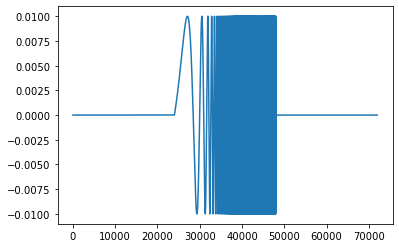

In [71]:
sr = 48000  # choose sample rate compatible with your sound card
gain = 0.01  # scale signal to avoid blowing loudspeakers
x = sfc.exponential_sweep(T=0.5, sr=sr, post_silence=0.5, pre_silence=0.5) * gain
plt.plot(x);

### Record sweeps

Before recording, make sure that you have selected the correct audio interface:

In [72]:
print(sd.query_devices())                       # print list of available devices
sd.default.device = 0                  # set default audio interface
#sd.default.samplerate = sr                     # set default sample rate

*  0 HDA Intel PCH: CX8200 Analog (hw:0,0), ALSA (2 in, 2 out)
   1 HDA Intel PCH: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
   2 HDA Intel PCH: HDMI 1 (hw:0,7), ALSA (0 in, 8 out)
   3 HDA Intel PCH: HDMI 2 (hw:0,8), ALSA (0 in, 8 out)
   4 HDA Intel PCH: HDMI 3 (hw:0,9), ALSA (0 in, 8 out)
   5 HDA Intel PCH: HDMI 4 (hw:0,10), ALSA (0 in, 8 out)
   6 sysdefault, ALSA (128 in, 128 out)
   7 front, ALSA (0 in, 2 out)
   8 surround40, ALSA (0 in, 2 out)
   9 surround51, ALSA (0 in, 2 out)
  10 surround71, ALSA (0 in, 2 out)
  11 hdmi, ALSA (0 in, 8 out)
  12 samplerate, ALSA (128 in, 128 out)
  13 speexrate, ALSA (128 in, 128 out)
  14 pulse, ALSA (32 in, 32 out)
  15 upmix, ALSA (8 in, 8 out)
  16 vdownmix, ALSA (6 in, 6 out)
  17 dmix, ALSA (0 in, 2 out)
  18 default, ALSA (32 in, 32 out)


The function `sfc.measure_via_audio_interface` can be used to play back the excitation signal and at the same time record the signal at the microphone. It is just a convienient wrapper around `sounddevice.playrec` for measuring multi-channel systems. For example

```python
# Play signal x twice simulataneosly over channels 1 and 2 while recording in channels 1 and 2.
y = sfc.measure_via_audio_interface(x, out_chs=[1, 2], in_ch=[1, 2], n_reps=2)
# First measure output 1, then output 2 and then both together
y = sfc.measure_via_audio_interface(x, out_chs=[[1], [2], [1, 2]], in_ch=[1, 2])
```

Sometimes, it is useful to measure through different ouputs with different excitations. For example, when validating a sound field control setup, one might want to record an excitation signal played back through the primary loudspeakers while the secondary loudspeakers play a different (optimized) signal.

```python
# First play back through channel 1, then through 1+2
output_channels = [[1], [1, 2]]
# feed channel 2 with a different signal (here reversed sweep signal)
x_second_reversed =  [x, np.stack((x, x[::-1]), axis=-1)]
# record at inputs 1 and 2
input_channels = [1, 2]
# play and record each set
y = sfc.measure_via_audio_interface(x_second_reversed, output_channels, in_ch=input_channels, n_reps=3)
```

For this example, we just want to measure both loudspeaker transfer-functions separately (My sound card seems to be low-quality: the first recording as a huge transient at the start. I just remove the first sweeps)

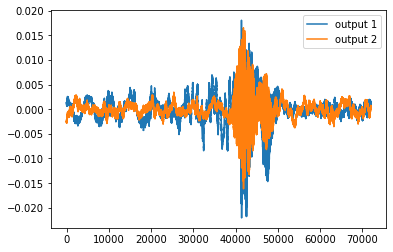

In [116]:
y = sfc.measure_via_audio_interface(x, out_chs=[[1], [2]], in_ch=[1], n_reps=5)
y = y[..., 1:]   # FIXME: removing first sweeps on this machine here due to bad sound card
plt.plot(y.mean(axis=-1));  # plot the mean over all repetitions
plt.legend([f"output {i}" for i in [1, 2]]);



It is good practice to divide your data into a train set for estimating your control filters and a test set to test your result.

In [75]:
y_train = y[..., :2]
y_test = y[..., 2:]

### Estimate impulse responses

Using the original excitation signal and the mean of the training data over the repetitions, we can estimate the impulse responses with `sfc.transfer_function(..., return_time=True)`.

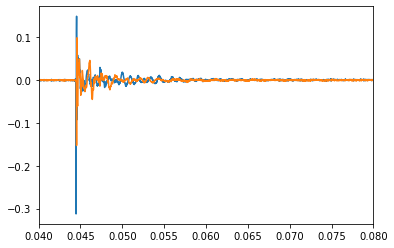

In [90]:
h = sfc.transfer_function(x, y_train.mean(axis=-1), return_time=True)
t = sfc.time_vector(h.shape[0], sr)
plt.plot(t, h);  # plot average response over repetitions
plt.xlim(0.04, 0.08);

We only want to cancel the direct sound, but the impulse response includes a lot of reflection paths and noise. Let's time window the responses

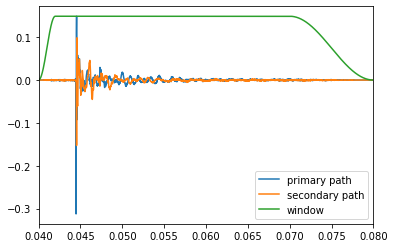

In [91]:
window = sfc.time_window(n=h.shape[0], sr=sr, startwindow=(0.040, 0.042), stopwindow=(0.07, 0.08))
h_windowed = (h.T * window).T  # last axis must match for broadcasting

p = h_windowed[:, 0]  # primary path impulse response
s = h_windowed[:, 1]  # secondary path impulse response

plt.plot(t, p, label='primary path')
plt.plot(t, s, label='secondary path')
plt.plot(t, window * np.max(h), label='window');
plt.xlim(0.04, 0.08);
plt.legend();

The `Response` class from the `response` package has some useful plotting utilities. Let's plot magnitude, phase and time response of our filters:

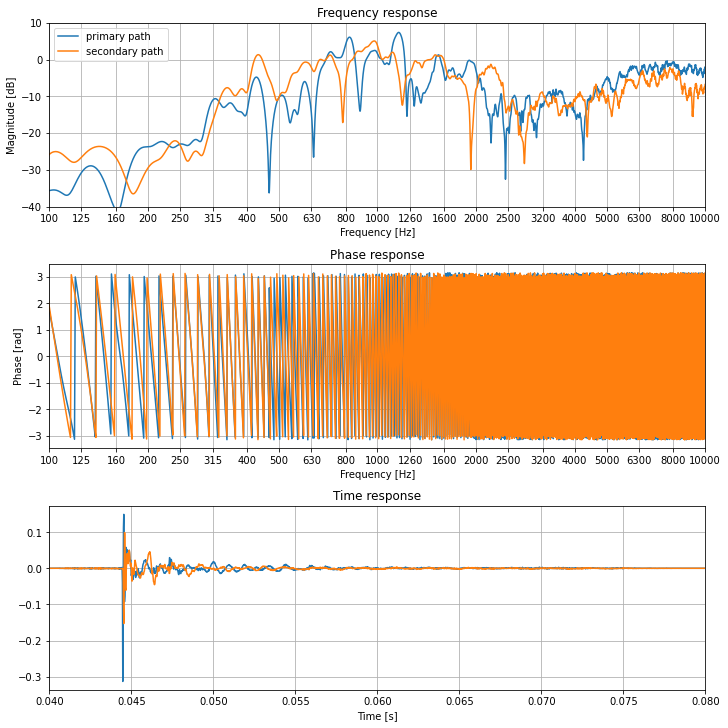

In [92]:
fig = Response.from_time(sr, p).plot(label='primary path')
Response.from_time(sr, s).plot(label='secondary path', use_fig=fig, tlim=(0.040, 0.08), flim=(100, 10000), dblim=(-40, 10));

### Optimal filter

The function `sfc.pressure_matching` computes our filter for each frequency.

Text(0.5, 1.0, 'Control FIR filter')

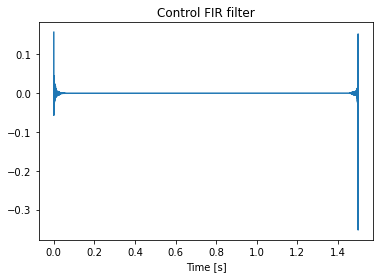

In [93]:
# frequency responses
P = np.fft.rfft(p)
S = np.fft.rfft(s)
# The function `sfc.pressure_matching` also works for multichannel systems
# and accepts arrays of 3 and 2 dimensions. Bring them into the appropriate shape.
P = P.reshape(-1, 1)      # the shape is (#frequencies, #microphones)
S = S.reshape(-1, 1, 1)   # the shape is (#frequencies, #microphones, #secondary loudspeakers)
# control filter in frequency domain at a single microphone
W = - sfc.pressure_matching(S, P, reg=1e-1)[..., 0]
# control filter in time domain
w = np.fft.irfft(W)
times = sfc.time_vector(w.shape[0], sr)
plt.plot(times, w);
plt.xlabel('Time [s]')
plt.title('Control FIR filter')

Our filter is non-causal (it has non-zero components at negative time index) so we could not use it for real-time applications. This was expected due to the complicated reflection paths around the laptop and the frequency-domain inverse filter design. Luckily, for our example, we can compute all signals offline before playback as we added some zeros to the beginning of our excitation signal `x`. 

### Testing

Because of 
$$\hat y=s*(w*x) = w*(s*x)$$
we can estimate $\hat y$ by convolving the recorded excitation of the secondary loudspeaker, $s * x$, with the control filter $w$. Then we can estimate the error signal $e = y + \hat y$. Let's use the test data here to avoid the [inverse crime](https://scicomp.stackexchange.com/questions/28225/first-appearance-of-the-phrase-inverse-crime). 

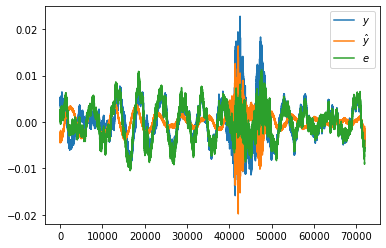

In [94]:
# convolve in frequency domain via circular convolution (check proper zero-padding)
y_hat = np.fft.irfft(np.fft.rfft(y_test[:, 1].T) * W).T
e = y_test[:, 0] + y_hat
plt.plot(y_test[:, 0].mean(axis=-1), label='$y$')
plt.plot(y_hat.mean(axis=-1), label='$\hat y$');
plt.plot(e.mean(axis=-1),label='$e$');
plt.legend();

The reduction in sound pressure level over frequency is the insertion loss
$$IL = \frac{|E|^2}{|Y|^2}\frac{|Y + Y_{hat}|^2}{|Y|^2}$$

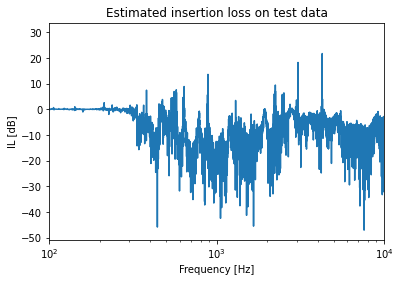

In [95]:
Y = np.fft.rfft(y_test[:, 0].mean(axis=-1))
Y_hat = np.fft.rfft(y_hat.mean(axis=-1))
E = Y + Y_hat
IL_test = 20 * np.log10(np.abs(E) / np.abs(Y))
# plot
freqs = sfc.frequency_vector(y_test.shape[0], sr)
plt.semilogx(freqs, IL_test)
plt.xlim(100, 10000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('IL [dB]');
plt.title('Estimated insertion loss on test data');

### Validation

Let's validate with a proper measurement. First we preconolve the excitation signal $x$ with the control filter $w$.

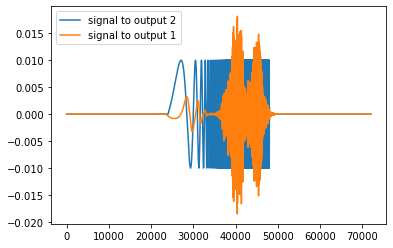

In [96]:
# convolve in frequency domain via circular convolution (check proper zero-padding)
x_controlled = np.fft.irfft(np.fft.rfft(x) * W)
plt.plot(x, label='signal to output 2')
plt.plot(x_controlled,label='signal to output 1');
plt.legend();

Then we measure the total signal $e$ by playing the excitation signal $x$ through the primay loudspeaker and the control signal $w*x$ through the control loudspeaker.

In [97]:
xstacked = np.stack((x, x_controlled), axis=1)
e = sfc.measure_via_audio_interface(xstacked, out_chs=[[1, 2]], in_ch=[1], n_reps=10)
e = e[..., 1:]  # on my machine only: remove first sweep due to bad sound card
e = e.mean(axis=-1)

Let's look at the insertion loss

(100, 10000)

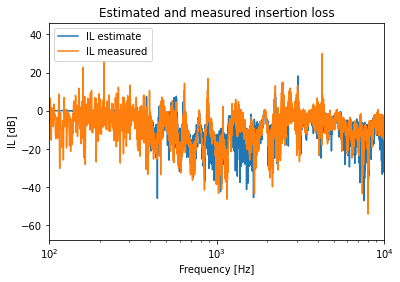

In [100]:
E = np.fft.rfft(e)
IL_valid = 20 * np.log10(np.abs(E) / np.abs(Y))
# plot
plt.semilogx(freqs, IL_test, label='IL estimate')
plt.semilogx(freqs, IL_valid, label='IL measured')
plt.xlabel('Frequency [Hz]')
plt.ylabel('IL [dB]');
plt.title('Estimated and measured insertion loss');
plt.legend();
plt.xlim(100, 10000)

Measurement and prediction can vary due to:

- time-varying systems (temperature, wind, loudspeaker)
- non-linear system (loudspeaker, microphones)
- noise at microphone
- causality

The validation measurement is really noisy. We can clean the insertion loss up if we compute it from the system impulse response (which we can nicely time window to remove noise).

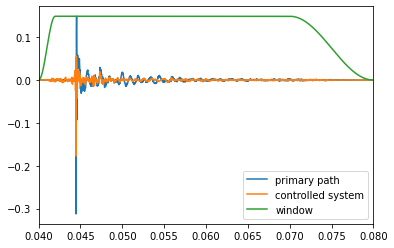

In [111]:
h_total = sfc.transfer_function(x, e, return_time=True) * window

plt.plot(t, p, label='primary path')
plt.plot(t, h_total, label='controlled system')
plt.plot(t, window * np.max(h), label='window');
plt.xlim(0.04, 0.08);
plt.legend();

Here is our result: the reduction of SPL over frequency estimated and measured. Yey!

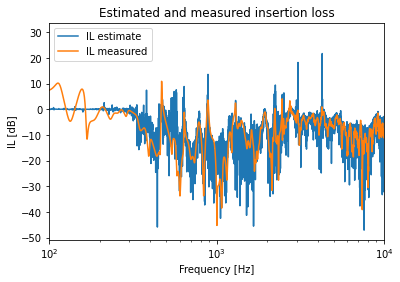

In [115]:
H_total = np.fft.rfft(h_total)
IL_valid_from_transfer_functions = 20 * np.log10(np.abs(H_total) / np.abs(P[:, 0]))
# plot
plt.semilogx(freqs, IL_test, label='IL estimate')
plt.semilogx(freqs, IL_valid_from_transfer_functions, label='IL measured')
plt.xlabel('Frequency [Hz]')
plt.ylabel('IL [dB]');
plt.title('Estimated and measured insertion loss');
plt.legend();
plt.xlim(100, 10000);

## Example 2: measurements with B&K front-end

In [2]:
# automatically reload modules (no kernel restart required while editing source files)
%load_ext autoreload
%autoreload 2
# load libraries
import sfc                       # module for sound field control room
import numpy as np               # numerical computations
import matplotlib.pyplot as plt  # plotting
import sounddevice as sd         # interface to sound cards
import soundfile as sf           # interface to audio files
import librosa                   # great audio analysis library
from response import Response    # convienience functions for impulse response processing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this example we will use an external front-end and a microphone array to record the responses of the loudspeaker excitations. We will specifically use a B&K front-end together with the BK Connect software. Apart from the details of BK Connect, you should also be able to go through this example code with any other recording system that lets itself be triggered via a change in signal input-level, records for a given duration and exports to WAV format.

### Problem

In this example we use a $M=5$ element loudspeaker array (black) and 2 control zones (blue, red) that are measured with the array with $N=60$ microphones. The control problem is as follows: the sound of loudspeaker 1 shall be reproduced with minimal distortion in the blue zone, while the total sound pressure level over the red zone shall be minimized.

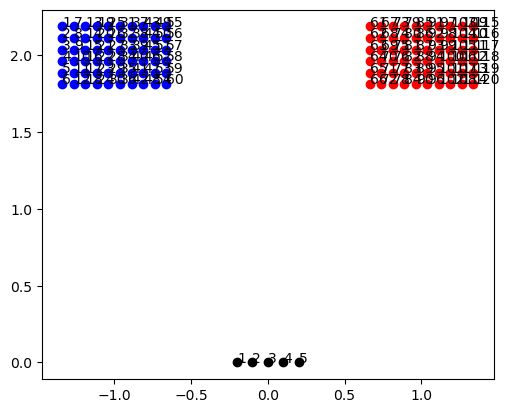

In [3]:
r_local = sfc.bk_planar_array_mic_positions()
r_center = r_local.mean(axis=-1, keepdims=True)
r_bright = r_local - r_center + [[-1], [2]]
r_dark = r_local - r_center + [[1], [2]]
n_ch = 5  # M
r_ls = np.stack((
    np.linspace(-0.2, 0.2, n_ch, endpoint=True),
    np.zeros(n_ch))
)
for i, r in enumerate(r_bright.T):
    plt.scatter(*r, color='blue')
    plt.text(*r, i + 1)
for i, r in enumerate(r_dark.T):
    plt.scatter(*r, color='red')
    plt.text(*r, i + r_local.shape[1] + 1)
for i, r in enumerate(r_ls.T):
    plt.scatter(*r, color='k')
    plt.text(*r, i + 1)
plt.gca().set_aspect('equal')

At a single frequency, let $h \in \mathbb C^{2N}$ be the vector of target transfer-functions and let $H \in \mathbb C^{2NxM}$ be the matrix of transfer-functions between the loudspeakers and the microphones locations. The goal is to find the loudspeaker weights $w \in \mathbb C^{M}$ as solution to the generalized least-squares (Ridge) problem

$$\min_w ||Hw-h||^2 + \lambda ||w||^2$$

### Experimental setup

To connect the computer to the loudspeakers make the following connections

- Computer --via Ethernet--> Ferrofish
- Ferrofish --via XLR--> multichannel amps
- multishannel-amps --via XLR--> loudspeakers

The connection between computer and Ferrofish is via the Dante Protocol. On the computer, start _Dante Virtual Soundcard_ via the Windows menu, select `local Ethernet` for the network interface and press `Start`. The list of available devices (`sd.query_devices()`) should now contain `Dante Virtual Soundcard`.

Select sample rate and Dante Virtual Soundcard as your default audio device

In [3]:
sr = 48000                                     # choose default sample rate
sd.default.device = 'Dante Virtual Soundcard'  # set default audio interface
sd.default.samplerate = sr                     # set default sample rate
# print(sd.query_devices())                    # uncomment this line to print list of available devices

It is also important to route the Dante transmission channels of your computer to the correct receiving channels of the Ferrofish. You can edit Dantes routing matrix in the `Dante Controller` app.

To connect the B&K front-end and array:

- B&K front-end --via Ethernet-> Computer
- Microphones --via LEMO-> B&K front-end 
- Ferrofish output 6 --via XLR cable with XLR-to-BNC adapter-> B&K front-end input 1

The last connection is for sending the excitation signal directly to the front-end, such that excitation signal and microphone signals are synchronized.

Open the _BK Connect front-end setup_ app to check wether the Ethernet connection is working. Select the front-end and save.

Use a switch to connect both the Ferrofish and the B&K interface with the same computer (you could also use two seperate computers).

### B&K Connect setup

Start _BK Connect_ and load the project `Recording with mic array for TF estimation`. 

Go to the "Set Up" tab to set up a trigger that starts a recording as soon as the reference signal (signal 1) is larger than the idle noise.

Next go to the "Measure" tab. Check that all microphones are properly connected. Press the wrench symbol on the right to open the recorder setting and make sure that "Start Recording" is set to "Reference Signal Trigger" and "Stop Recording" is set to "Duration" with 25 seconds (you will find out below why exactly this length). Chose a name for "Next recording" and then press the big red record button. The recording will not start directly but should wait for the trigger signal to go over the activation level.

### Generate excitation signal

We use a little bit of a different approach compared to the last example. Due to the external interface, it is easiest to create one large multi-channel excitation signal that sweeps through all channels sequentially, and cut the recording into chunks afterwards.

In Time Data Recorder under `Recorder settings` set `Duration Sec` to  27.5 seconds


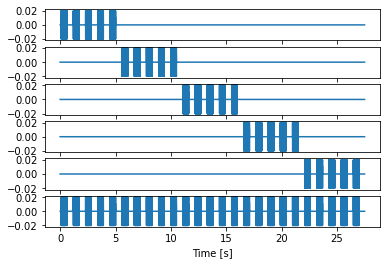

In [4]:
n_ch = 5  # number of single output channels / loudspeakers measured in series
n_reps = 5  # number of signal repetitions for each channel
gain = 0.02  # signal gain
x = gain * sfc.exponential_sweep(T=0.5, sr=sr, fade=0, f_start=100, f_end=10000, post_silence=0.5, pre_silence=0.1)
# create a multichannel version of x. The last channel x[:, -1] containes
# a reference signal, which we route via an extra output channel (#6) directly into the B&K front-end
xmult = sfc.multichannel_signal(x, n_ch=n_ch, n_reps=n_reps, add_reference=True)
print("In Time Data Recorder under `Recorder settings` set `Duration Sec` to ", xmult.shape[0] / sr, "seconds")
fig, ax = plt.subplots(nrows=n_ch+1)
t = sfc.time_vector(xmult.shape[0], sr)
for i in range(n_ch+1):
    ax[i].plot(t, xmult[:, i])
ax[-1].set_xlabel('Time [s]');

Make one recording with the array in the blue zone and one with the array in the red zone. Make sure the trigger is correctly specified and the Time Data Recorder is waiting for the trigger. Then execute the following cell to play back the multi-channel sweep.

In [5]:
# add an extra reference output
reference_output_channel = 6
output_channels = [1, 2, 3, 4, 5, reference_output_channel]
# play back the signal
sd.play(xmult, sr, mapping=output_channels)

In BK Connect, go to the "Process" tab, select the two recordings in the tree view on the left, right-click and select "Export data to files". Export the recordings as WAV to the "data" folder in this repository.

Let's inspect the recordings. The function `sfc.load_bk_wav_recording` automatically cuts the recording into a multidimensional array according to the number of repetitions and the number of measured output channels.

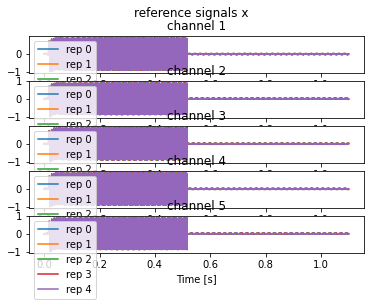

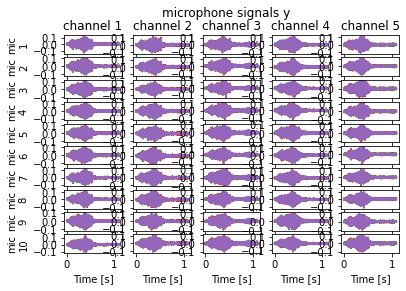

In [6]:
x, y, srbk = sfc.load_bk_wav_recording('data/bluezone-1.wav', n_ch=n_ch, n_reps=n_reps)
# plot reference signal x with shape (n_samp, 1, n_ch, n_reps)
fig, ax = plt.subplots(nrows=n_ch)
t = sfc.time_vector(x.shape[0], srbk)
for channel in range(n_ch):
    ax[channel].plot(t, x[:, 0, channel])
    ax[channel].legend([f'rep {i}' for i in range(n_reps)])
    ax[channel].set_title(f'channel {channel + 1}')
    ax[channel].set_xlabel('Time [s]')
plt.suptitle('reference signals x')
# plot microphone signals y with shape (n_samp, n_mics, n_ch, n_reps)
fig, ax = plt.subplots(ncols=n_ch, nrows=10)
for channel in range(n_ch):
    ax[0, channel].set_title(f"channel {channel + 1}")
    ax[-1, channel].set_xlabel('Time [s]')
    for mic in range(10):
        ax[mic, 0].set_ylabel(f"mic\n{mic + 1}")
        ax[mic, channel].plot(t, y[:, mic, channel])
plt.suptitle('microphone signals y');

NOTE: When I did these experiments there was a lot of humming noise on the reference signal. Hopefully someone has found a solution when you read this.

### Estimate transfer-functions

We again split our data in test and training sets. I split here only the repetitions, but one should also split the microphone locations into two sets to test generalizability properly.

In [8]:
# load recordings
xb, yb, sr = sfc.load_bk_wav_recording("data/bluezone-1.wav", n_ch=n_ch, n_reps=5)
xr, yr, sr = sfc.load_bk_wav_recording("data/redzone-1.wav", n_ch=n_ch, n_reps=5)

# test-train split
xb_train, xb_test = xb[..., :3], xb[..., 3:]
xr_train, xr_test = xr[..., :3], xr[..., 3:]
yb_train, yb_test = yb[..., :3], yb[..., 3:]
yr_train, yr_test = yr[..., :3], yr[..., 3:]

We estimate the transfer-function with the regularization parameter chosen as the noise to signal ratio.

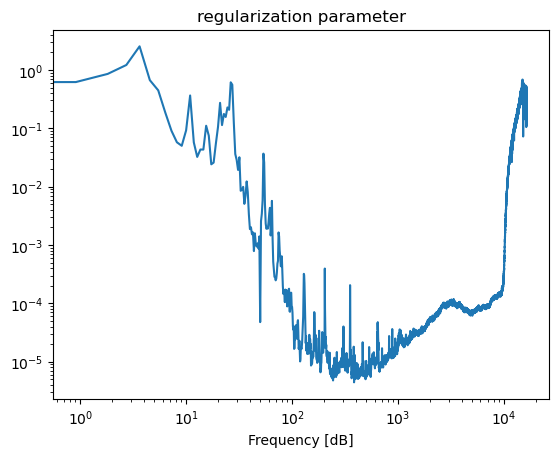

In [9]:
# set regularization parameter to mean over noise to signal estimates
reg = np.stack((
    sfc.estimate_noise_to_signal_ratio(xb_train,yb_train),
    sfc.estimate_noise_to_signal_ratio(xr_train,yr_train)
)).mean(axis=0)
# plot
freqs = sfc.frequency_vector(xb_train.shape[0], srbk)
plt.loglog(freqs, reg);
plt.xlabel('Frequency [dB]')
plt.title('regularization parameter');

The room in which I do the experiment is quite reverberant. This can be an issue for the control, as the optimal filter in frequency domain will turn out to be highly non-causal. We window the impulse responses around the direct sound using `sfc.time_window_around_peak` to avoid any issues. This means that only the direct sound from the loudspeakers will be controlled.

In [10]:
out = []
for x, y in ((xb_train, yb_train), (xr_train, yr_train), (xb_test, yb_test), (xr_test, yr_test)):
    # TF estimation with taking mean over repetitions
    h = sfc.transfer_function(x, y, reg=reg).mean(axis=-1)
    # cut after 10 milliseconds
    h = h[:int(0.010*srbk)]
    # time windowing around the direct sound
    window = sfc.time_window_around_peak(h, srbk, tleft=0.001, tright=0.002, window='tukey', param=0.3)
    h *= window
    out.append(h)
hb_train, hr_train, hb_test, hr_test = out

The windowed responses and the windows look like this

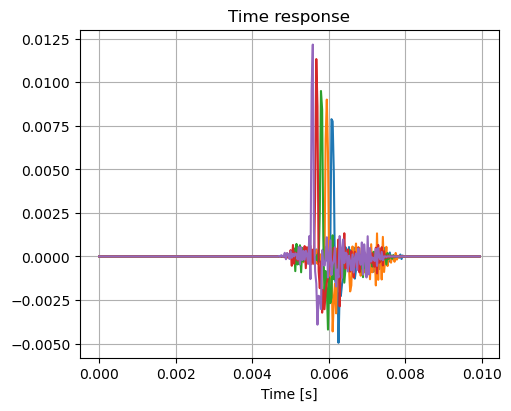

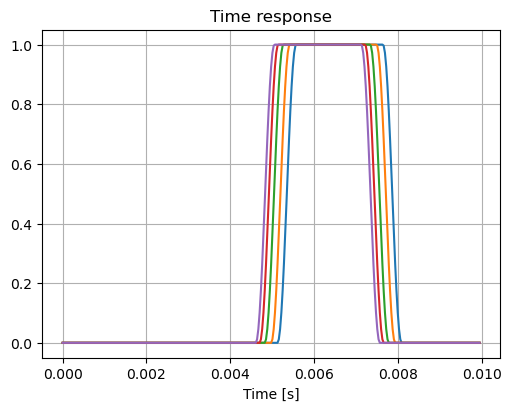

In [11]:
Response.from_time(sr, hr_train[:, 10].T).plot_time(figsize=(5,4))
Response.from_time(sr, window[:, 10].T).plot_time(figsize=(5,4));

### Optimal filter

Compute filters using the training set

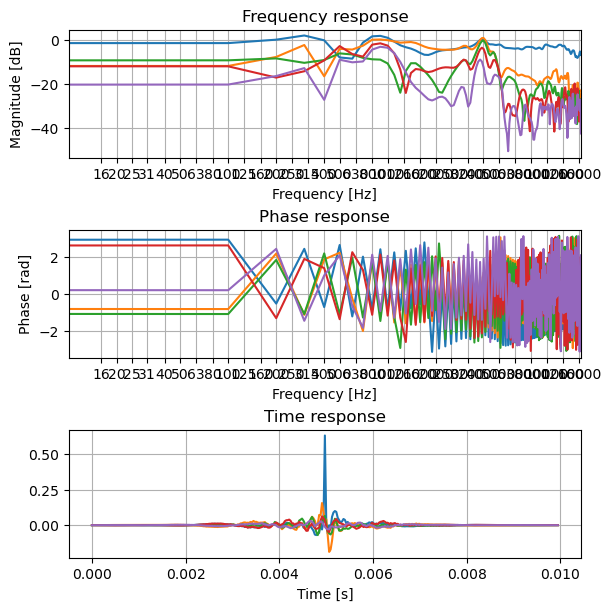

In [13]:
# the target response in the blue zone  is the response of loudspeaker 1 and in the red zone is 0
h_target = np.concatenate((hb_train[..., 0], np.zeros(hb_train.shape[:-1])), axis=1)
H = np.concatenate((hb_train, hr_train), axis=1)

# compute filter using pressure-matching
W = sfc.pressure_matching(
    np.fft.rfft(H, axis=0),
    np.fft.rfft(h_target, axis=0),
    reg=1e-4
)
# in time domain
w = np.fft.irfft(W, axis=0, n=h_target.shape[0])
# make filters causal: circular shift them around half the filter length
w = np.roll(w, w.shape[0]//2, axis=0)
# plot filtes
Response.from_time(sr, w.T).plot(figsize=(6, 6));

As one can see, the filters are non-causal, so they have to be circularly shifted before convolution.

### Testing

Estimate performance using the test set. In the last example we convolved the filters with the microphone signals and used these to estimate the total performance. Because of the externel interface, the microphone signals `y` for different microphone indices are not synchronized, so we can not use that approach here. Instead, we convolve the transfer-functions of the test set (which are synchronized as `x` and `y` is synchronized for each loudspeaker) with the control filter to estimate the created transfer-functions in the two zones.

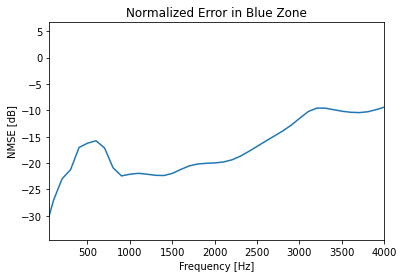

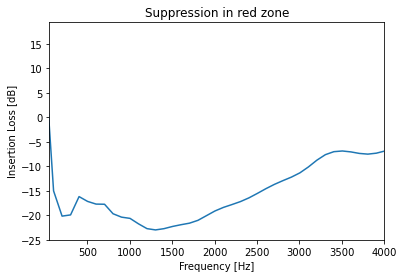

In [12]:
# Loudspeaker responses with filters applied
HW = np.einsum('fnm,fm->fn', np.fft.rfft(H, axis=0), W)
# target response in frequency domain
H_target = np.fft.rfft(h_target, axis=0)

# Normalized mean square error in blue zone
nmse = (np.abs(HW[:, :60] - H_target[:, :60])**2 / np.abs(H_target[:, :60])**2).mean(axis=-1)
# reduction of sound in the red zone
il = (np.abs(HW[:, 60:])**2 / np.abs(np.fft.rfft(H, axis=0)[:, 60:, 0])**2).mean(axis=-1)

freqs = sfc.frequency_vector(H.shape[0], srbk)
plt.figure()
plt.plot(freqs, 10*np.log10(nmse))
plt.xlabel('Frequency [Hz]')
plt.ylabel('NMSE [dB]')
plt.title('Normalized Error in Blue Zone');
plt.xlim(50, 4000)
plt.figure()
plt.plot(freqs, 10*np.log10(il))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Insertion Loss [dB]')
plt.title('Suppression in red zone');
plt.xlim(50, 4000);

### Listening test

Let's prepare a little listning test to observe the sound field personally.

In [13]:
# load a demo clip and resample it to the default sample rate of our audio device
x, _ = librosa.load('songs/Sample_BeeMoved_96kHz24bit.flac', sr=sr, mono=True, offset=15, duration=5)
# resample filters to sample rate of sound card
w_resampled = librosa.resample(w.T, orig_sr=srbk, target_sr=sr).T
# filter demo clip (equivalent to np.linalg.convolve for each filter)
xfilt = sfc.olafilt(w_resampled, x[:, None], 'nl,nk->nl')

Play, listen, enjoy.

In [14]:
# uncontrolled case: just play back through speaker 1
sd.play(0.05 * x, sr, mapping=1, blocking=True)
# controlled case: play filtered signal
sd.play(0.05 * xfilt, sr, mapping=[1, 2, 3, 4, 5], blocking=True)

Save filter for use in next example

In [15]:
import soundfile as sf
# save filter for next example
sf.write('data/w_resampled.wav', w_resampled, sr, subtype='FLOAT')

## Example 3: real-time convolution with MAX

Instead of preconvolving a known full signal, we can also convolve a signal in real-time using MAX. A patch implementing a multichannel convolver is at `data/convolver.maxpat`. We use the filters from the last example (`data/w_resampled.wav`).

Follow the steps in the speach bubble to convolve your signal in real-time!